# Coordinate Transfromation between $r$ and $r_*$

Code to transform from $r$ to $r_*$ and back. $r$ to $r_*$ is trivial:

\begin{align*}
r \rightarrow r_* = r + 2M \ln{\left(\frac{r}{2M} - 1\right)}
\end{align*}

To obtain the inverse transformation, $r_* \rightarrow r$ the substitution $x = \frac{r}{2M} - 1 \Rightarrow r = 2M\left(x+1\right)$ is used:

\begin{align*}
\Rightarrow r_* &= 2M(x + 1) + 2M\ln{x} \\
\Rightarrow \frac{r_*}{2M} - 1 &= x + \ln{x} \\
\Rightarrow \exp{\left(\frac{r_*}{2M} - 1\right)} &= x \text{e}^{x}
\end{align*}

Now using the definition of the Lambert W function, $\text{W}\left(\varphi e^{\varphi}\right) = \varphi$, to invert this expression, we get that 
\begin{align*}
x &= \text{W}\left(\exp{\left(\frac{r_*}{2M} - 1\right)}\right) \\
\Rightarrow r &= 2M\left[1 + \text{W} \left(\exp{\left(\frac{r_*}{2M} - 1\right)}\right)\right]
\end{align*}
Since $\varphi = x = \frac{r}{2M} - 1 \ge 0$ for behaviour outside the event horizon (area of interest), it suffices to use only the $k=0$ branch of the Lambert W function (per scipy).

In [24]:
import numpy as np 
from scipy.special import lambertw
import matplotlib.pyplot as plt

M = 1
r_array = np.array([ 2*M, 4*M, np.inf])

r_star = []
for r in r_array:
    r_tortoise = r + 2*M*np.log(r/(2*M) - 1)
    r_star.append(r_tortoise)

r_star = np.array(r_star)
print(r_star)

r_inverse = []
for rs in r_star:
    r_inv = 2*M*(1 + lambertw(np.exp(rs/(2*M) - 1), k = 0))
    r_inverse.append(r_inv)

r_inverse = np.array(r_inverse)
print(r_inverse.real)

[-inf   4.  inf]
[ 2.  4. inf]


C:\Users\danie\AppData\Local\Temp\ipykernel_24116\2764763046.py:10: RuntimeWarning: divide by zero encountered in log
  r_tortoise = r + 2*M*np.log(r/(2*M) - 1)
C:\Users\danie\AppData\Local\Temp\ipykernel_24116\2764763046.py:18: RuntimeWarning: invalid value encountered in scalar multiply
  r_inv = 2*M*(1 + lambertw(np.exp(rs/(2*M) - 1), k = 0))


Code works and coordinates transform as expected. The RuntimeWarning might be an issue but I'll run with it for now. Also might have an issue with infinities for the PINN, may need to map infinities to $\pm 1$.

In [ ]:
def r_to_rstar(r, M):
    r = np.asarray(r)
    if np.any(r <= 2*M):
        raise ValueError("All r must be > 2M")
    return r + 2*M * np.log(r/(2*M) - 1)

def rstar_to_r(rs, M):
    rs = np.array(rs)
    return (2*M * (1 + lambertw(np.exp(rs/(2*M) - 1)))).real

-15.0 30.0
2.0004068539645283 25.106100973033477


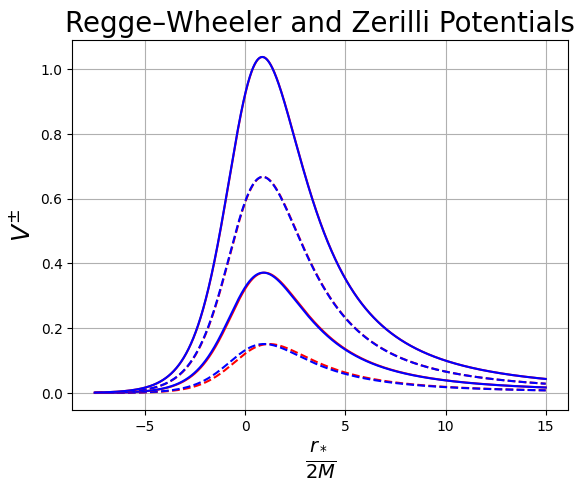

In [106]:
M = 1
rstar = np.linspace(-15, 30, 3000)
print(rstar[0], rstar[-1])
r = rstar_to_r(rstar, M)
print(r[0], r[-1])

def Vpm(r, M, l, parity):
    if parity == 'axial':
        V = (1-2*M/r)*(l*(l+1)/r**2 - 6*M/r**3)
    elif parity == 'polar':
        n = 1/2*(l-1)*(l+2)
        num = 2*(1-2*M/r)*(
            9*M**3 +
            9*n*M**2*r + 
            3*n**2*M*r**2 + 
            n**2*(1 + n)*r**3
        )
        den = r**3*(3*M + n*r)**2
        V = num/den
    else:
        raise ValueError("parity needs to be either: axial or polar")
    return V

ls = [2, 3, 4, 5]
Nr = len(rstar)

V_all = np.zeros((len(ls), 2, Nr))

for i, l in enumerate(ls):
    V_all[i, 0] = Vpm(r, M, l, 'axial')
    V_all[i, 1] = Vpm(r, M, l, 'polar')

for i in range(V_all.shape[0]):
    axial = V_all[i, 0]
    polar = V_all[i, 1]
    linestyle = '--' if i % 2 == 0 else '-'

    plt.plot(rstar/(2*M), axial, color = 'red', linestyle = linestyle)
    plt.plot(rstar/(2*M), polar, color = 'blue', linestyle = linestyle)

plt.xlabel(r'$\frac{r_*}{2M}$', fontsize = 20)
plt.ylabel(r'$V^{\pm}$', fontsize = 18)
plt.title("Regge–Wheeler and Zerilli Potentials", fontsize=20)
plt.grid('True')
plt.show()

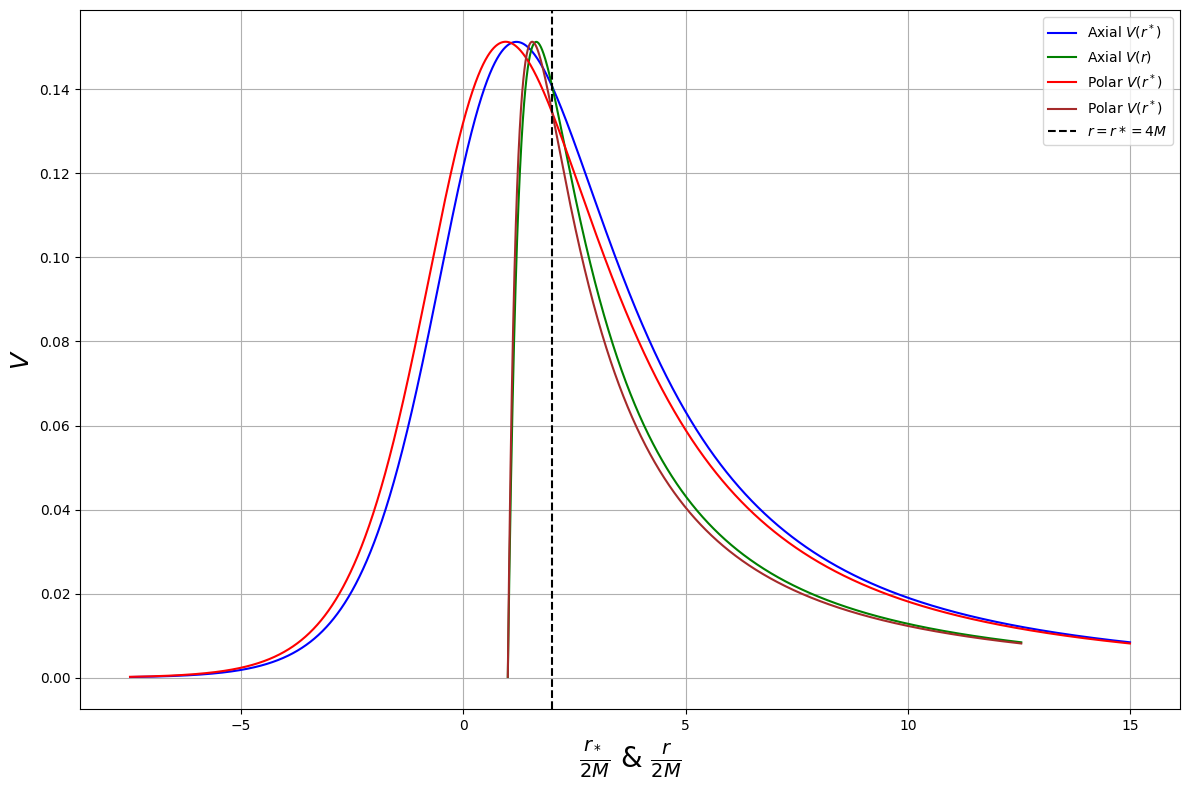

In [112]:
plt.figure(figsize = [12, 8])
plt.plot(rstar/(2*M), V_all[0, 0], color = 'blue', label = r'Axial $V\left(r^*\right)$')
plt.plot(r/(2*M), V_all[0, 0], color = 'green', label = r'Axial $V\left(r\right)$')
plt.plot(rstar/(2*M), V_all[0, 1], color = 'red', label = r'Polar $V\left(r^*\right)$')
plt.plot(r/(2*M), V_all[0, 1], color = 'brown', label = r'Polar $V\left(r^*\right)$')
plt.axvline(2, 0, 1, color = 'black', linestyle = '--', label = r'$r = r* = 4M$')
plt.xlabel(r'$\frac{r_*}{2M}$ & $\frac{r}{2M}$', fontsize = 20)
plt.ylabel(r'$V$', fontsize = 18)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()